In [13]:
import datautil
from os import path
import importlib
importlib.reload(datautil)

<module 'datautil' from '/home/sfluor/projects/driving_dataset/datautil.py'>

In [14]:
df, loader, scaler = datautil.create_loader(400, workers=8)

In [15]:
df.describe()

,steering,steering_scaled
count,45406.000000,45406.000000
mean,1.745058,0.244329
std,30.916780,0.046723
min,-159.930000,0.000000
25%,-5.450000,0.233456
50%,1.010000,0.243218
75%,8.870000,0.255097
max,501.780000,1.000000


In [16]:
import torchvision.models as models
import torch.nn as nn
import torch

model = models.resnet18(pretrained=True)

# Strip the last linear layer
model.fc = nn.Sequential()

In [17]:
# Test on an image
in_tensor = datautil.load_img(df['image'].values[0]).unsqueeze(0)

print(in_tensor.shape)

with torch.no_grad():
    output = model(in_tensor)

print(output.shape)

torch.Size([1, 3, 224, 224])
torch.Size([1, 512])


In [18]:
(X, y) = datautil.extract_features(model, loader)

In [19]:
print(X.shape, y.shape)

(400, 512) (400,)


In [20]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [21]:
import xgboost

regr = xgboost.XGBRegressor()

In [22]:
regr.fit(X_train, y_train)

[15:42:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

MSE Error: 0.012646720744669437, max error: 0.5833594799041748


Text(0, 0.5, 'ground truth')

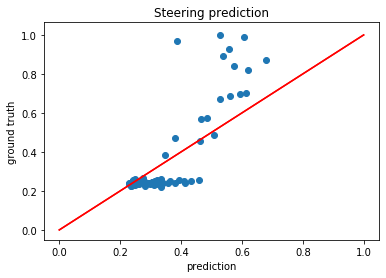

In [30]:
import sklearn.metrics as metrics
import matplotlib.pyplot as plt

plt.ion()

y_pred = regr.predict(X_test)

print(f"MSE Error: {metrics.mean_squared_error(y_pred, y_test)}, max error: {metrics.max_error(y_pred, y_test)}")

plt.scatter(y_pred, y_test)
plt.plot([[0, 0], [1, 1]], color='red')
plt.title("Steering prediction")
plt.xlabel("prediction")
plt.ylabel("ground truth")

In [31]:
p = datautil.Pipeline(model, regr)

In [32]:
p.predict([datautil.load_img(df['image'].values[100], process=False)])

array([0.23788679], dtype=float32)